<a href="https://colab.research.google.com/github/AnkushVe/Wall-Color-Visualizer/blob/main/SAM_realtime_using_sam_with_multiple_frames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segment-anything

In [2]:
#Downloading the model
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-09-10 11:20:23--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.82, 13.35.7.50, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  90.9MB/s    in 21s     

2023-09-10 11:20:45 (114 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
import cv2
import os,time
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

In [ ]:
#initilizing the model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Video to frames


In [ ]:
def convert_video_to_frames(video_path, output_directory):
    cap = cv2.VideoCapture(video_path)

    os.makedirs(output_directory, exist_ok=True)

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_directory, f"frame_{frame_count:04d}.jpg")
        #frame = cv2.Canny(frame, threshold1=1, threshold2=35)
        cv2.imwrite(frame_path, frame)
        frame_count += 1
    cap.release()

    print(f"Converted {frame_count} frames from the video to {output_directory}")

# Segmentation Functions

In [ ]:
def show_mask(mask, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image, color

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# Per Frame Segmentation

input coordinates are given in input_point variable which has to be tracked

In [ ]:
def segmentation_per_frame():
  count = 1
  segmented_output_directory = "segmented_output"
  frames = sorted([f for f in os.listdir(output_directory) if f.endswith(".jpg")])
  if not frames:
    print("No frame images found in the directory.")
    return
  else:
    for i in frames:
      start_time = time.time()
      os.makedirs(segmented_output_directory, exist_ok=True)

      image_path = os.path.join(output_directory,i)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      image_output_directory = os.path.join(segmented_output_directory,i)

      #setting the image to sam model
      predictor.set_image(image)

      input_point = np.array([[750, 250]]) #-----------------here------------------
      input_label = np.array([1])

      #masks variable has the masks of the segmentaion
      masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
      )

      #creating a new image to save the segmentation overlayed with image with 4 channels(r,g,b,alpha)
      segmented_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
      segmented_image[:, :, :3] = image[:,:,:3]
      segmented_image[:, :, 3] = 255

      for i, (mask, score) in enumerate(zip(masks, scores)):

          mask_image, color = show_mask(mask)

          #for every segmented pixel storing that pixel information in new image
          for i in range(len(segmented_image)):
              for j in range(len(segmented_image[i])):
                  if mask[i][j] == True:
                      segmented_image[i][j] = np.array([30, 144, 255,255*0.6])

          #point stored in image
          segmented_image[250, 750] = [0,0,0,255]

          plt.imsave(image_output_directory,
              segmented_image,
          )
          end_time = time.time()
          print(f"Frame {count} is done. Time taken is {end_time-start_time}")
          count+=1

# Segmentation Frames to Video

In [ ]:
def create_video_from_frames(frame_directory, output_video_path, frame_rate):
    frame_files = [f for f in os.listdir(frame_directory) if f.endswith(".jpg")]

    if not frame_files:
        print("No frame images found in the directory.")
        return
    frame_files.sort()

    first_frame = cv2.imread(os.path.join(frame_directory, frame_files[0]))
    frame_height, frame_width, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(
        output_video_path, fourcc, frame_rate, (frame_width, frame_height)
    )

    for frame_file in frame_files:
        frame_path = os.path.join(frame_directory, frame_file)
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Video created at: {output_video_path}")

# Process

In [ ]:
video_path = "/content/pexels-curtis-adams-15887128 (720p).mp4"
output_directory = "frames_output"

In [ ]:
convert_video_to_frames(video_path, output_directory)

Converted 460 frames from the video to frames_output


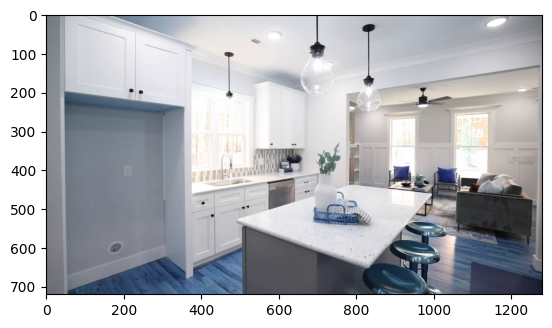

In [ ]:
image = cv2.imread("/content/frames_output/frame_0000.jpg")
plt.imshow(image)
plt.show()

In [ ]:
segmentation_per_frame()

Frame 1 is done. Time taken is 3.0107107162475586
Frame 2 is done. Time taken is 2.9841554164886475
Frame 3 is done. Time taken is 3.3001794815063477
Frame 4 is done. Time taken is 3.0049502849578857
Frame 5 is done. Time taken is 2.985175371170044
Frame 6 is done. Time taken is 2.9693896770477295
Frame 7 is done. Time taken is 3.3362200260162354
Frame 8 is done. Time taken is 2.9948649406433105
Frame 9 is done. Time taken is 2.969552993774414
Frame 10 is done. Time taken is 3.012908935546875
Frame 11 is done. Time taken is 3.302273750305176
Frame 12 is done. Time taken is 3.0272672176361084
Frame 13 is done. Time taken is 3.022068977355957
Frame 14 is done. Time taken is 2.995853900909424
Frame 15 is done. Time taken is 3.2378973960876465
Frame 16 is done. Time taken is 2.9645235538482666
Frame 17 is done. Time taken is 2.9701743125915527
Frame 18 is done. Time taken is 2.966001272201538
Frame 19 is done. Time taken is 3.3172364234924316
Frame 20 is done. Time taken is 2.9562373161315

In [ ]:
frame_directory = "segmented_output"
output_video_path = "Segmented_video.avi"
frame_rate = 60

In [ ]:
create_video_from_frames(frame_directory, output_video_path, frame_rate)

Video created at: Segmented_video.avi
